### Import Required Packages

In [1]:
# ---------------------------- STEP 1: Import Packages ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

# Device Setup (CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)


Using Device: cuda


### Import Google Drive Mount

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Images Folders Transformations

In [7]:
# ---------------------------- STEP 2 & 3: Drive Import + Transformations ----------------------------
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


### Loader Dataset Path 

In [17]:
# ---------------------------- STEP 4: Dataset Path + Loader ----------------------------
train_path = "/content/drive/MyDrive/Smart Vison AI/classification/train"
test_path  = "/content/drive/MyDrive/Smart Vison AI/classification/test"


train_ds = datasets.ImageFolder(train_path, transform=train_tf)
test_ds  = datasets.ImageFolder(test_path, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

classes = train_ds.classes
num_classes = len(classes)
print("Classes:", classes)


Classes: ['airplane', 'bed', 'bench', 'bicycle', 'bird', 'bottle', 'bowl', 'bus', 'cake', 'car', 'cat', 'chair', 'couch', 'cow', 'cup', 'dog', 'elephant', 'horse', 'motorcycle', 'person', 'pizza', 'potted plant', 'stop sign', 'traffic light', 'truck']


### Load Pretrained VGG16, Freeze, Custom Classifier

In [ ]:
# ---------------------------- STEP 5: Load Pretrained VGG16 + Freeze + Custom Classifier ----------------------------
vgg16 = models.vgg16(pretrained=True)


for param in vgg16.features[-6:].parameters():
    param.requires_grad = True


vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

vgg16 = vgg16.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Optimizer, Loss Function

In [64]:
# ---------------------------- STEP 6: Optimizer + Loss Function ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)


### Training Loop

In [65]:
# ---------------------------- STEP 7: Training Loop ----------------------------
epochs = 20

for epoch in range(epochs):
    start = time.time()
    vgg16.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    elapsed = time.time() - start

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.3f} | Train Acc: {train_acc:.2f}% | Time: {elapsed:.2f}s")


Epoch 1/20 | Loss: 68.782 | Train Acc: 30.61% | Time: 13.32s
Epoch 2/20 | Loss: 29.143 | Train Acc: 71.50% | Time: 13.47s
Epoch 3/20 | Loss: 17.119 | Train Acc: 82.13% | Time: 13.44s
Epoch 4/20 | Loss: 10.984 | Train Acc: 88.08% | Time: 13.47s
Epoch 5/20 | Loss: 9.140 | Train Acc: 90.30% | Time: 13.51s
Epoch 6/20 | Loss: 7.150 | Train Acc: 92.52% | Time: 13.66s
Epoch 7/20 | Loss: 5.791 | Train Acc: 94.28% | Time: 13.59s
Epoch 8/20 | Loss: 5.007 | Train Acc: 95.44% | Time: 13.82s
Epoch 9/20 | Loss: 3.911 | Train Acc: 96.26% | Time: 13.76s
Epoch 10/20 | Loss: 4.067 | Train Acc: 94.98% | Time: 13.80s
Epoch 11/20 | Loss: 3.481 | Train Acc: 96.26% | Time: 13.92s
Epoch 12/20 | Loss: 3.202 | Train Acc: 96.73% | Time: 13.94s
Epoch 13/20 | Loss: 2.732 | Train Acc: 96.96% | Time: 13.91s
Epoch 14/20 | Loss: 2.586 | Train Acc: 97.08% | Time: 13.95s
Epoch 15/20 | Loss: 2.261 | Train Acc: 97.43% | Time: 14.17s
Epoch 16/20 | Loss: 2.200 | Train Acc: 96.96% | Time: 14.01s
Epoch 17/20 | Loss: 1.892 | T

### Test Accuracy

In [66]:
# ---------------------------- STEP 8: Test Accuracy ----------------------------
vgg16.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"\nTest Accuracy = {test_acc:.2f}%")



Test Accuracy = 88.04%


### Confusion Matrix

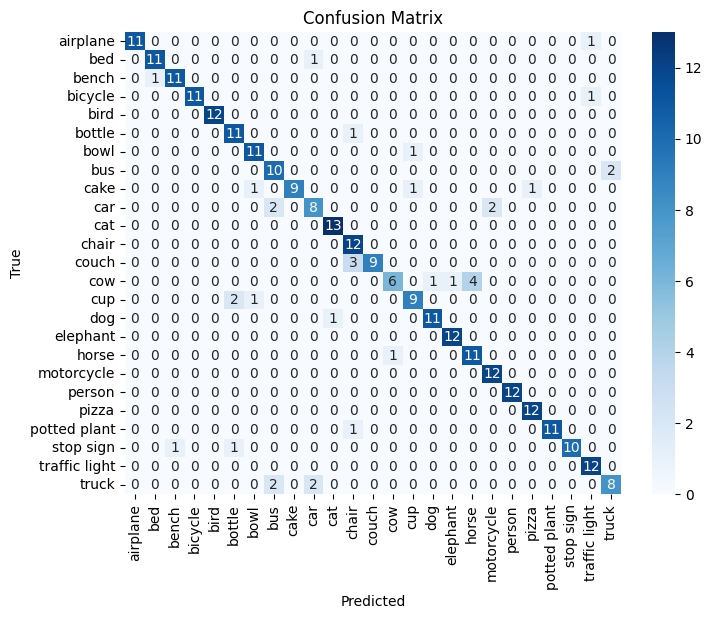


Classification Report:

               precision    recall  f1-score   support

     airplane       1.00      0.92      0.96        12
          bed       0.92      0.92      0.92        12
        bench       0.92      0.92      0.92        12
      bicycle       1.00      0.92      0.96        12
         bird       1.00      1.00      1.00        12
       bottle       0.79      0.92      0.85        12
         bowl       0.85      0.92      0.88        12
          bus       0.71      0.83      0.77        12
         cake       1.00      0.75      0.86        12
          car       0.73      0.67      0.70        12
          cat       0.93      1.00      0.96        13
        chair       0.71      1.00      0.83        12
        couch       1.00      0.75      0.86        12
          cow       0.86      0.50      0.63        12
          cup       0.82      0.75      0.78        12
          dog       0.92      0.92      0.92        12
     elephant       0.92      1.00     

In [24]:
# ---------------------------- STEP 8: Confusion Matrix ----------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


### Save Trined Model

In [42]:
import os

save_path = "/content/drive/MyDrive/Smart Vison AI/VGG16.pth"
torch.save(vgg16.state_dict(), save_path)
print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/Smart Vison AI/VGG16.pth


### Load Pretrained EfficientNet, Freeze, Custom Classifier

In [ ]:
# ----------------------------  Load Pretrained Efficientnet + Freeze + Custom Classifier ----------------------------
model = models.efficientnet_b0(pretrained=True)


for param in model.features.parameters():
    param.requires_grad = False


num_classes = len(classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

model = model.to(device)

### Optimizer, Loss Function

In [ ]:
# ----------------------------  Optimizer + Loss Function ----------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)



### Training Loop

In [ ]:
# ----------------------------  Training Loop ----------------------------
epochs = 20

for epoch in range(epochs):
    start = time.time()
    model.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    elapsed = time.time() - start

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.3f} | "
    f"Train Acc: {train_acc:.2f}% | Time: {elapsed:.2f}s")

Epoch 1/20 | Loss: 6.625 | Train Acc: 94.51% | Time: 10.40s
Epoch 2/20 | Loss: 6.737 | Train Acc: 93.81% | Time: 9.52s
Epoch 3/20 | Loss: 6.558 | Train Acc: 93.46% | Time: 9.37s
Epoch 4/20 | Loss: 6.604 | Train Acc: 93.22% | Time: 8.19s
Epoch 5/20 | Loss: 6.428 | Train Acc: 92.64% | Time: 9.51s
Epoch 6/20 | Loss: 5.856 | Train Acc: 93.93% | Time: 8.97s
Epoch 7/20 | Loss: 6.083 | Train Acc: 93.69% | Time: 8.50s
Epoch 8/20 | Loss: 5.313 | Train Acc: 94.39% | Time: 9.58s
Epoch 9/20 | Loss: 6.007 | Train Acc: 94.16% | Time: 9.15s
Epoch 10/20 | Loss: 6.288 | Train Acc: 93.57% | Time: 8.49s
Epoch 11/20 | Loss: 4.940 | Train Acc: 95.44% | Time: 9.53s
Epoch 12/20 | Loss: 4.811 | Train Acc: 96.38% | Time: 9.05s
Epoch 13/20 | Loss: 5.076 | Train Acc: 95.33% | Time: 8.47s
Epoch 14/20 | Loss: 5.149 | Train Acc: 95.33% | Time: 9.54s
Epoch 15/20 | Loss: 5.551 | Train Acc: 94.98% | Time: 9.32s
Epoch 16/20 | Loss: 5.377 | Train Acc: 94.28% | Time: 8.28s
Epoch 17/20 | Loss: 5.117 | Train Acc: 95.21% | 

### Test Accuracy

In [ ]:
# ----------------------------  Test Accuracy ----------------------------
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"\nTest Accuracy = {test_acc:.2f}%")



Test Accuracy = 86.71%


### Confusion Matrix

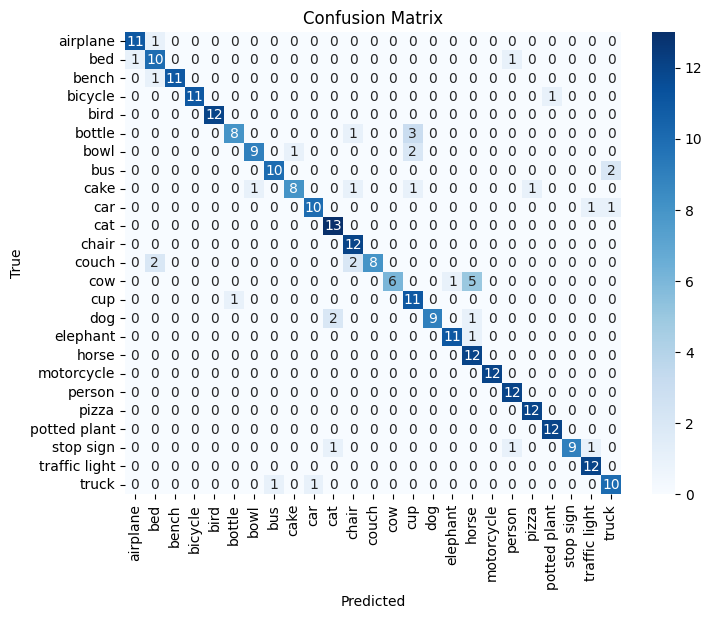


Classification Report:

               precision    recall  f1-score   support

     airplane       0.92      0.92      0.92        12
          bed       0.71      0.83      0.77        12
        bench       1.00      0.92      0.96        12
      bicycle       1.00      0.92      0.96        12
         bird       1.00      1.00      1.00        12
       bottle       0.89      0.67      0.76        12
         bowl       0.90      0.75      0.82        12
          bus       0.91      0.83      0.87        12
         cake       0.89      0.67      0.76        12
          car       0.91      0.83      0.87        12
          cat       0.81      1.00      0.90        13
        chair       0.75      1.00      0.86        12
        couch       1.00      0.67      0.80        12
          cow       1.00      0.50      0.67        12
          cup       0.65      0.92      0.76        12
          dog       1.00      0.75      0.86        12
     elephant       0.92      0.92     

In [ ]:
# ----------------------------  Confusion Matrix ----------------------------

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


###  Save Trined Model

In [40]:
save_path = "/content/drive/MyDrive/Smart Vison AI/efficientnet_best.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/Smart Vison AI/efficientnet_best.pth


### MobileNet, Freeze, Custom Classifier

In [ ]:
# ----------------------------  Load Pretrained MobileNet + Freeze + Custom Classifier ----------------------------

mobilenet = models.mobilenet_v2(pretrained=True)

for param in mobilenet.features.parameters():
    param.requires_grad = False

num_classes = len(classes)
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

mobilenet = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Optimizer, Loss Function

In [ ]:
# ----------------------------  Optimizer + Loss Function ----------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)


### Training Loop

In [ ]:
# ----------------------------  Training Loop ----------------------------
epochs = 20

for epoch in range(epochs):
    start = time.time()
    mobilenet.train()
    total, correct, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    elapsed = time.time() - start

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.3f} | "
    f"Train Acc: {train_acc:.2f}% | Time: {elapsed:.2f}s")

Epoch 1/20 | Loss: 5.200 | Train Acc: 94.98% | Time: 9.62s
Epoch 2/20 | Loss: 4.414 | Train Acc: 95.68% | Time: 9.36s
Epoch 3/20 | Loss: 4.740 | Train Acc: 95.79% | Time: 8.38s
Epoch 4/20 | Loss: 5.129 | Train Acc: 95.21% | Time: 9.49s
Epoch 5/20 | Loss: 4.699 | Train Acc: 94.74% | Time: 9.36s
Epoch 6/20 | Loss: 4.535 | Train Acc: 96.03% | Time: 8.14s
Epoch 7/20 | Loss: 3.950 | Train Acc: 96.61% | Time: 9.62s
Epoch 8/20 | Loss: 5.155 | Train Acc: 94.39% | Time: 9.43s
Epoch 9/20 | Loss: 4.103 | Train Acc: 96.38% | Time: 8.21s
Epoch 10/20 | Loss: 3.555 | Train Acc: 96.61% | Time: 9.58s
Epoch 11/20 | Loss: 4.475 | Train Acc: 94.98% | Time: 9.53s
Epoch 12/20 | Loss: 4.519 | Train Acc: 94.51% | Time: 8.07s
Epoch 13/20 | Loss: 3.901 | Train Acc: 96.03% | Time: 9.67s
Epoch 14/20 | Loss: 3.836 | Train Acc: 96.50% | Time: 9.66s
Epoch 15/20 | Loss: 4.403 | Train Acc: 95.91% | Time: 9.56s
Epoch 16/20 | Loss: 3.584 | Train Acc: 95.79% | Time: 9.55s
Epoch 17/20 | Loss: 3.375 | Train Acc: 96.85% | T

###  Test Accuracy 

In [ ]:
# ----------------------------  Test Accuracy ----------------------------

mobilenet.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"\nTest Accuracy = {test_acc:.2f}%")



Test Accuracy = 88.04%


### Confusion Matrix

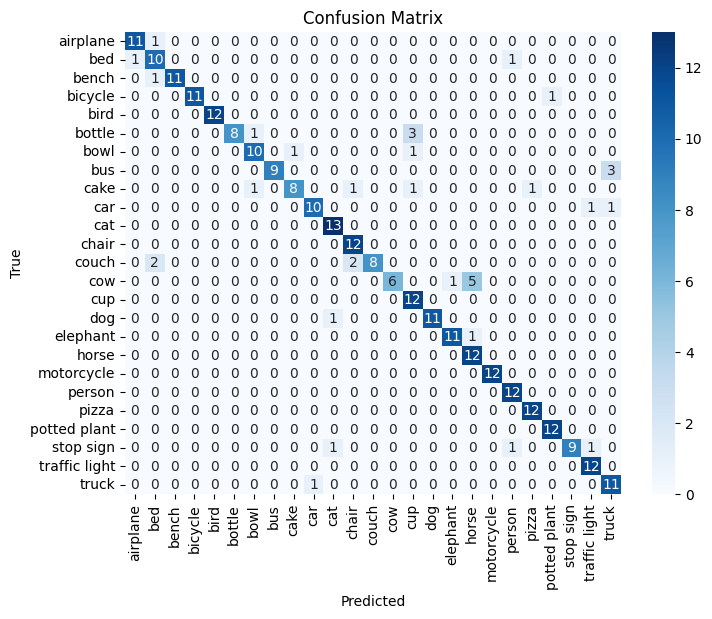


Classification Report:

               precision    recall  f1-score   support

     airplane       0.92      0.92      0.92        12
          bed       0.71      0.83      0.77        12
        bench       1.00      0.92      0.96        12
      bicycle       1.00      0.92      0.96        12
         bird       1.00      1.00      1.00        12
       bottle       1.00      0.67      0.80        12
         bowl       0.83      0.83      0.83        12
          bus       1.00      0.75      0.86        12
         cake       0.89      0.67      0.76        12
          car       0.91      0.83      0.87        12
          cat       0.87      1.00      0.93        13
        chair       0.80      1.00      0.89        12
        couch       1.00      0.67      0.80        12
          cow       1.00      0.50      0.67        12
          cup       0.71      1.00      0.83        12
          dog       1.00      0.92      0.96        12
     elephant       0.92      0.92     

In [ ]:
# ----------------------------  Confusion Matrix ----------------------------

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

### Save Trined Model

In [54]:
import os

save_path = "/content/drive/MyDrive/Smart Vison AI/MobileNET_best.pth"
torch.save(mobilenet.state_dict(), save_path)
print("Model saved to:", save_path)

Model saved to: /content/drive/MyDrive/Smart Vison AI/MobileNET_best.pth
